In [3]:
import os
import zipfile
import shutil
from pathlib import Path
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
# Fix all randomness for reproducibility
import os
import random
import numpy as np
import tensorflow as tf

# Set seeds
os.environ['PYTHONHASHSEED'] = '42'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Enable deterministic GPU operations (slower but reproducible)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

# Clear session (if re-running in the same kernel)
tf.keras.backend.clear_session()


In [6]:
from google.colab import files
uploaded = files.upload()

Saving archive.zip to archive.zip


In [5]:
import zipfile
import os
from pathlib import Path
import shutil
import random

with zipfile.ZipFile("archive.zip", 'r') as zip_ref:
    zip_ref.extractall("unzipped_data")

# Define the base folder after extraction
raw_data_dir = Path("unzipped_data/The IQ-OTHNCCD lung cancer dataset")


FileNotFoundError: [Errno 2] No such file or directory: 'archive.zip'

In [4]:

# Create cleaned structure
clean_base = Path("Cleaned_Dataset")
for split in ['train', 'valid', 'test']:
    for label in ['Cancer', 'Non_Cancer']:
        (clean_base / split / label).mkdir(parents=True, exist_ok=True)

# Map folder names to binary labels
cancer_folders = ["Benign cases", "Malignant cases"]
non_cancer_folders = ["Normal cases"]



In [5]:
# Collect images and assign labels
image_paths = []
labels = []

for folder in raw_data_dir.iterdir():
    if folder.name in cancer_folders:
        label = "Cancer"
    elif folder.name in non_cancer_folders:
        label = "Non_Cancer"
    else:
        continue

    for img_file in folder.glob("*.*"):
        if img_file.suffix.lower() in ['.png', '.jpg', '.jpeg']:
            image_paths.append(img_file)
            labels.append(label)

# Split into train (70%), valid (15%), test (15%)
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=0.3, stratify=labels, random_state=42)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)


In [6]:
# Utility function to copy
def copy_to_structure(paths, labels, split):
    for path, label in zip(paths, labels):
        filename = path.name
        target = clean_base / split / label / filename
        counter = 1
        while target.exists():
            target = clean_base / split / label / f"{path.stem}_{counter}{path.suffix}"
            counter += 1
        shutil.copy(path, target)

copy_to_structure(train_paths, train_labels, "train")
copy_to_structure(val_paths, val_labels, "valid")
copy_to_structure(test_paths, test_labels, "test")


📁 Dataset Distribution:
       Cancer  Non_Cancer
Train     392         291
Valid      85          62
Test       84          63


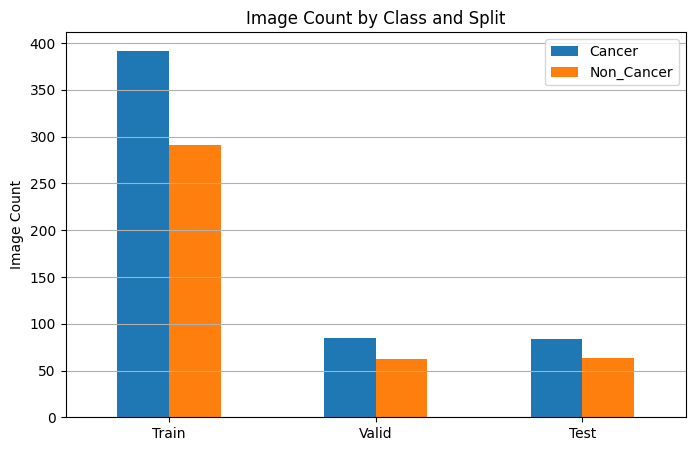

In [7]:
import pandas as pd

# Count images per class per split
def count_images(split):
    return {
        "Cancer": len(list((clean_base / split / "Cancer").glob("*.*"))),
        "Non_Cancer": len(list((clean_base / split / "Non_Cancer").glob("*.*")))
    }

train_counts = count_images("train")
valid_counts = count_images("valid")
test_counts  = count_images("test")

dist_df = pd.DataFrame([train_counts, valid_counts, test_counts], index=["Train", "Valid", "Test"])
print("📁 Dataset Distribution:")
print(dist_df)

# Optional: Plot class balance
dist_df.plot(kind="bar", stacked=False, figsize=(8,5), title="Image Count by Class and Split")
plt.ylabel("Image Count")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()


In [25]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
import os


In [47]:
base_dir = '/content/Cleaned_Dataset'  # Replace if different
img_height, img_width = 224, 224
batch_size = 32


In [2]:
# Augment only on training data
# Stronger augmentation for Cancer class (0)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,       # Increased from 20
    zoom_range=0.3,         # Increased from 0.2
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',    # Prevents black edges
    width_shift_range=0.1,  # New augmentation
    height_shift_range=0.1  # New augmentation
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    seed=42,  # Add this
    shuffle=True  # Explicitly enable shuffling
)


valid_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'valid'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Disable shuffling for validation
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


NameError: name 'ImageDataGenerator' is not defined

In [49]:
# Compute class weights to handle imbalance
class_weights = {0: 1.5, 1: 1}  # Give more weight to Cancer class (0)
print("Adjusted class weights:", class_weights)

Adjusted class weights: {0: 1.5, 1: 1}


In [52]:
from tensorflow.keras import layers, models, Input, regularizers

# Define input shape
input_shape = (img_height, img_width, 3)
inputs = Input(shape=input_shape)

# CNN layers
x = layers.Conv2D(32, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.01))(inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.3)(x)  # Added dropout after each block

x = layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(128, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

# Define the functional model
# Transfer learning with MobileNetV2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze pretrained layers

model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Lower LR for fine-tuning
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [54]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,            # Stop after 5 epochs without improvement
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=50,             # Increase max epochs
    callbacks=[early_stopping],
    class_weight=class_weights
)



Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 27s 928ms/step - accuracy: 0.5670 - loss: 0.9638 - val_accuracy: 0.7687 - val_loss: 0.4854
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 464ms/step - accuracy: 0.7993 - loss: 0.5321 - val_accuracy: 0.8980 - val_loss: 0.3346
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 414ms/step - accuracy: 0.8352 - loss: 0.4085 - val_accuracy: 0.9048 - val_loss: 0.2632
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 432ms/step - accuracy: 0.8642 - loss: 0.3376 - val_accuracy: 0.9252 - val_loss: 0.2190
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 494ms/step - accuracy: 0.9188 - loss: 0.2781 - val_accuracy: 0.9388 - val_loss: 0.1920
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 465ms/step - accuracy: 0.9225 - loss: 0.2194 - val_accuracy: 0.9320 - val_loss: 0.1668
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 453ms/step - accuracy: 0.9115 - loss: 0.2435 - val_accuracy: 0.9320 - val_loss: 0.1714
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 450ms/step - accuracy: 0.9458 - loss: 0.1973 - val_accur

In [55]:
# Evaluate on test set
# Generate predictions and find optimal threshold
from sklearn.metrics import roc_curve

y_pred_probs = model.predict(test_generator)
fpr, tpr, thresholds = roc_curve(test_generator.classes, y_pred_probs)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Apply threshold to get new predictions
y_pred_optimized = (y_pred_probs > optimal_threshold).astype(int).flatten()

# Re-evaluate metrics
print("\n🔧 Optimized Threshold:", optimal_threshold)
print(classification_report(test_generator.classes, y_pred_optimized))

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 773ms/step

🔧 Optimized Threshold: 0.19649482
              precision    recall  f1-score   support

           0       0.99      0.98      0.98        84
           1       0.97      0.98      0.98        63

    accuracy                           0.98       147
   macro avg       0.98      0.98      0.98       147
weighted avg       0.98      0.98      0.98       147



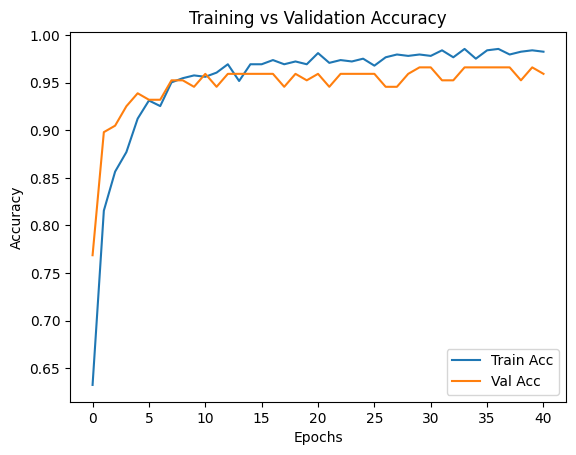

In [56]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()


In [57]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt


In [58]:
# Get predicted probabilities
y_pred_probs = model.predict(test_generator)
# Convert to binary labels (threshold at 0.5)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Get true labels
y_true = test_generator.classes


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step


In [59]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# Classification report
report = classification_report(y_true, y_pred)
print("\nClassification Report:\n", report)


Confusion Matrix:
 [[83  1]
 [ 2 61]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98        84
           1       0.98      0.97      0.98        63

    accuracy                           0.98       147
   macro avg       0.98      0.98      0.98       147
weighted avg       0.98      0.98      0.98       147



EVALUATION MATRIX

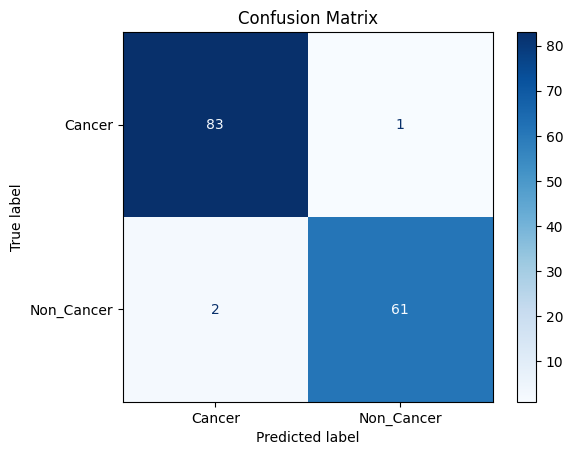

In [60]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [85]:
# 1. Save the model using recommended Keras format (instead of HDF5)
model.save('lung_cancer_cnn.keras')  # Changed from .h5 to .keras

# 2. Save test predictions
cnn_test_probs = model.predict(test_generator)
cnn_test_preds = (cnn_test_probs > optimal_threshold).astype(int)

# Convert numpy float32 to native Python float for JSON serialization
preprocessing_config = {
    'img_height': int(img_height),  # Convert to Python int
    'img_width': int(img_width),    # Convert to Python int
    'optimal_threshold': float(optimal_threshold),  # Convert to Python float
    'class_indices': {k: int(v) for k, v in test_generator.class_indices.items()}  # Convert all to int
}

# 3. Save preprocessing config
import json
with open('cnn_config.json', 'w') as f:
    json.dump(preprocessing_config, f)

# 4. Save predictions as numpy files
import numpy as np
np.save('cnn_test_probs.npy', cnn_test_probs)
np.save('cnn_test_preds.npy', cnn_test_preds)

# 5. Download all files
from google.colab import files
files.download('lung_cancer_cnn.keras')
files.download('cnn_config.json')
files.download('cnn_test_probs.npy')
files.download('cnn_test_preds.npy')

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>